In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

In [2]:
df = sns.load_dataset("titanic")
df = df[["age", "fare", "pclass", "sex", "survived"]]
df = df.dropna()
df['sex'] = df['sex'].replace("male", 0)
df['sex'] = df['sex'].replace("female", 1)
np.random.seed(23)
df_train, df_test = np.split(df, [600])

Suppose we want to compare the performance of several different models.

One way is by individually performing a GridSearchCV on each model type.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier()
parameters = {'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]}

dt_model_finder = GridSearchCV(decision_tree, parameters, cv=10)
dt_model_finder.fit(df_train[["age", "fare", "pclass", "sex"]],
                    df_train["survived"])
dt_model_finder.best_score_

0.7916666666666666

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

logistic_regression_model = Pipeline([('scale', StandardScaler()),
                                      ('model', LogisticRegression())])

parameters = {'model__C': 10**np.linspace(-7, 5, 100)}
lr_model_finder = GridSearchCV(logistic_regression_model, parameters, cv=10)
lr_model_finder.fit(df_train[["age", "fare", "pclass", "sex"]],
                    df_train["survived"])
lr_model_finder.best_score_

#Note, above we use GridSearchCV instead of LogisticRegressionCV. That is, the code above is
#almost the same thing as:
#logistic_regression_model = Pipeline([
#    ('scale', StandardScaler()),
#    ('model', LogisticRegressionCV(Cs = 10**np.linspace(-7, 5, 100)))
#])
#logistic_regression_model.fit(df_train[["age", "fare", "pclass",  "sex"]], df_train["survived"]);
;

0.79

We can also see all of the cross validation scores with `cv_results_`

In [5]:
dt_model_finder.cv_results_

{'mean_fit_time': array([0.00319045, 0.00259037, 0.00249336, 0.00229244, 0.00199478]),
 'std_fit_time': array([9.75647641e-04, 8.00442705e-04, 4.98605002e-04, 4.55217542e-04,
        3.38016674e-07]),
 'mean_score_time': array([0.00099804, 0.00109773, 0.00109727, 0.0008976 , 0.00079913]),
 'std_score_time': array([0.00044586, 0.0005351 , 0.00069842, 0.00053707, 0.00039959]),
 'param_min_impurity_decrease': masked_array(data=[0, 0.01, 0.02, 0.05, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_impurity_decrease': 0},
  {'min_impurity_decrease': 0.01},
  {'min_impurity_decrease': 0.02},
  {'min_impurity_decrease': 0.05},
  {'min_impurity_decrease': 0.1}],
 'split0_test_score': array([0.68333333, 0.71666667, 0.78333333, 0.8       , 0.8       ]),
 'split1_test_score': array([0.73333333, 0.73333333, 0.73333333, 0.76666667, 0.76666667]),
 'split2_test_score': array([0.75      , 0.71666667, 0.75      , 0.75   

#### Approach 2: Using a Dictionary of Dictionaries to Compare Many Model Types

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

all_models = {
    'DecisionTree':
        DecisionTreeClassifier(),
    'RandomForest':
        RandomForestClassifier(),
    'LogisticRegression':
        Pipeline([('scale', StandardScaler()),
                  ('model', LogisticRegression())]),
    'KNearestNeighbors':
        KNeighborsClassifier()
}

all_params = {
    'RandomForest': {
        "n_estimators": [50, 100, 200],
        'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]
    },
    'DecisionTree': {
        'min_impurity_decrease': [0, 0.01, 0.02, 0.05, 0.1]
    },
    'LogisticRegression': {
        'model__C': 10**np.linspace(-7, 5, 100)
    },
    'KNearestNeighbors': {
        'n_neighbors': [3, 4, 5, 8, 10]
    }
}

In [7]:
for name in all_models.keys():
    model = all_models[name]
    params = all_params[name]
    gscv = GridSearchCV(estimator=model, param_grid=params, cv=10)
    gscv.fit(df_train[["fare", "age", "pclass", "sex"]], df_train["survived"])
    print(f"best parameters are: {gscv.best_estimator_}")
    print(f"accuracy is: {gscv.best_score_}")

best parameters are: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.02, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
accuracy is: 0.7916666666666666
best parameters are: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
  

Above, we see the Random Forest model does slightly better than a decision tree or logistic regression model, with average cross-validation accuracy of 0.805.

### Beyond Accuracy: Recall, Precision, and Sensitivity (and more)

In [8]:
best_decision_tree = dt_model_finder.best_estimator_
decision_tree_predictions = best_decision_tree.predict(
    df_train[["age", "fare", "pclass", "sex"]])

best_logistic_model = lr_model_finder.best_estimator_
logistic_predictions = best_logistic_model.predict(
    df_train[["age", "fare", "pclass", "sex"]])

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train["survived"], decision_tree_predictions)

0.7916666666666666

In [10]:
accuracy_score(df_train["survived"], logistic_predictions)

0.79

In [11]:
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(df_train["survived"], decision_tree_predictions)
cm_dt

array([[349,   7],
       [118, 126]], dtype=int64)

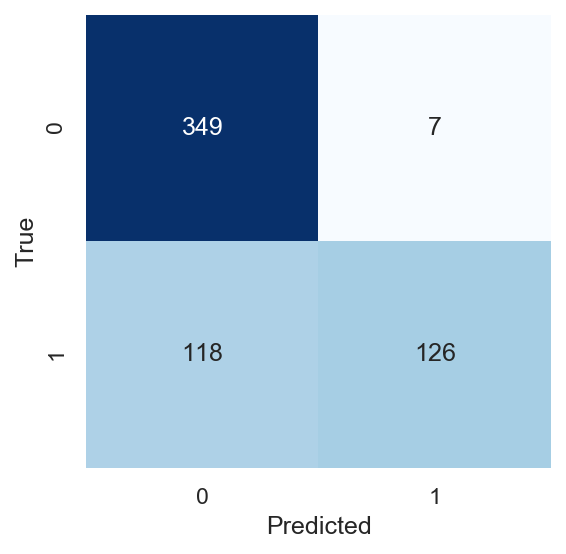

In [12]:
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
sns.set(font_scale=2)
plt.savefig("cm_dt.png", dpi=300, bbox_inches="tight")

In [13]:
cm_lr = confusion_matrix(df_train["survived"], logistic_predictions)
cm_lr

array([[310,  46],
       [ 80, 164]], dtype=int64)

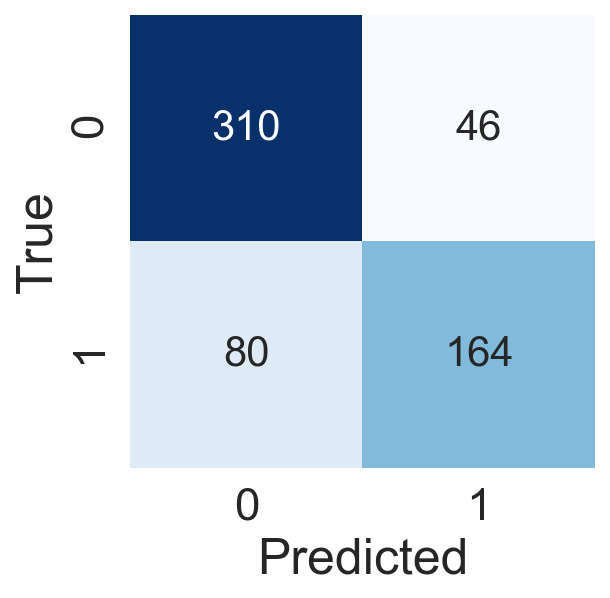

In [14]:
sns.heatmap(cm_lr,
            annot=True,
            fmt="d",
            cmap="Blues",
            annot_kws={"size": 20},
            cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
sns.set(font_scale=2)
plt.savefig("cm_lr.png", dpi=300, bbox_inches="tight")

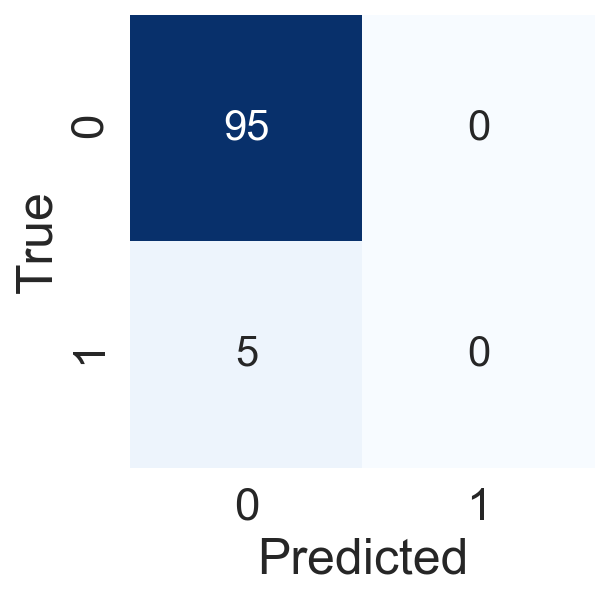

In [15]:
sns.heatmap([[95, 0], [5, 0]],
            annot=True,
            fmt="d",
            cmap="Blues",
            annot_kws={"size": 20},
            cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
sns.set(font_scale=2)
plt.savefig("cm_ex2.png", dpi=300, bbox_inches="tight")

#### Effect of Threshold on Model

In [21]:
def predict_with_threshold(probabilities, T):
    p1 = probabilities[:, 1]
    return 1 * (p1 > T)

In [22]:
predict_with_threshold(np.array([[0.6, 0.4], [0.3, 0.7], [0.1, 0.9]]), 0.5)

array([0, 1, 1])

In [23]:
predict_with_threshold(np.array([[0.6, 0.4], [0.3, 0.7], [0.1, 0.9]]), 0.75)

array([0, 0, 1])

In [24]:
lm_probabilities = best_logistic_model.predict_proba(
    df_train[["age", "fare", "pclass", "sex"]])

In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def show_confusion_matrix_and_print_accuracy_and_recall(reality, predictions):
    cm = confusion_matrix(reality, predictions)
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                annot_kws={"size": 20},
                cbar=False)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    sns.set(font_scale=2)
    print(f"Precision: {precision_score(reality, predictions)}")
    print(f"Recall: {recall_score(reality, predictions)}")
    #plt.savefig("cm_t50.png", dpi = 300, bbox_inches = "tight")

Precision: 0.780952380952381
Recall: 0.6721311475409836


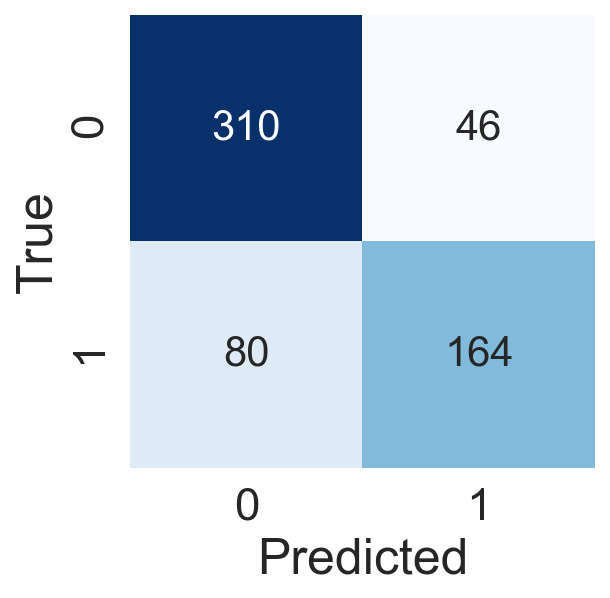

In [27]:
t50_predictions = predict_with_threshold(lm_probabilities, 0.50)
show_confusion_matrix_and_print_accuracy_and_recall(df_train["survived"],
                                                    t50_predictions)

Precision: 0.9214285714285714
Recall: 0.5286885245901639


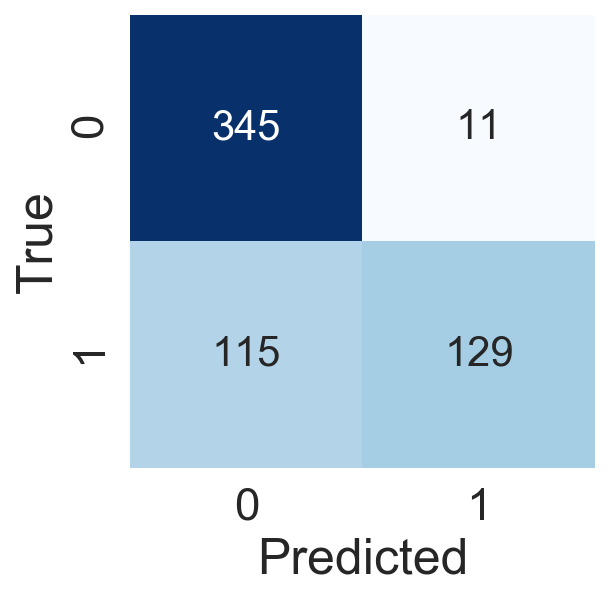

In [29]:
show_confusion_matrix_and_print_accuracy_and_recall(
    df_train["survived"], predict_with_threshold(lm_probabilities, 0.60))

Precision: 0.9615384615384616
Recall: 0.3073770491803279


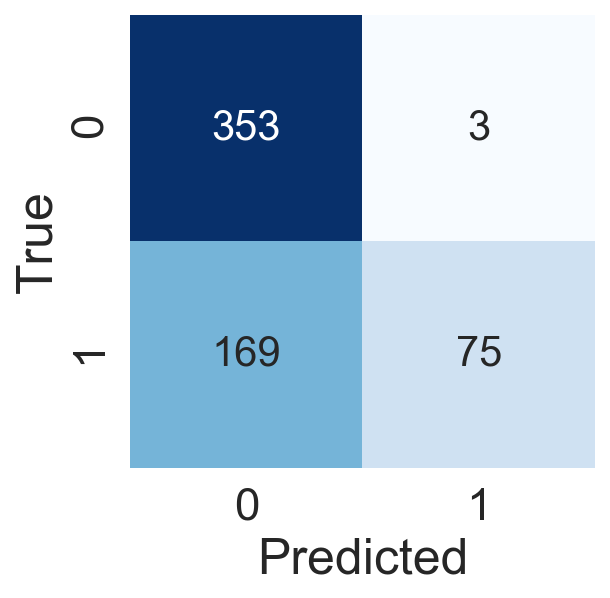

In [30]:
t70_predictions = predict_with_threshold(lm_probabilities, 0.70)
show_confusion_matrix_and_print_accuracy_and_recall(df_train["survived"],
                                                    t70_predictions)

Precision: 0.9428571428571428
Recall: 0.13524590163934427


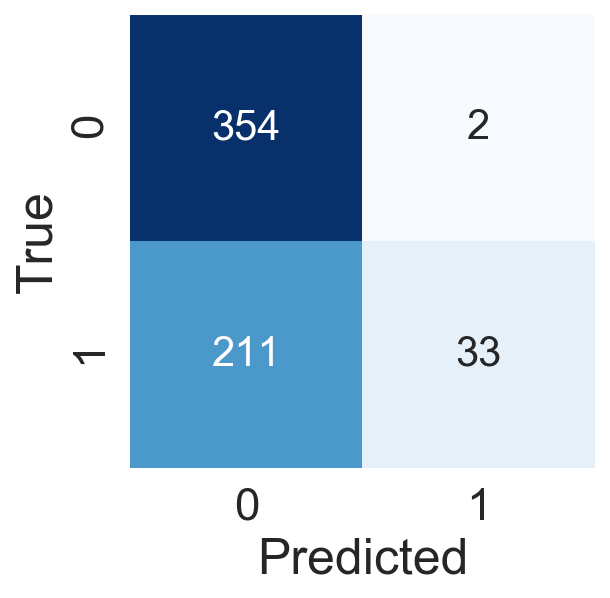

In [31]:
t80_predictions = predict_with_threshold(lm_probabilities, 0.80)
show_confusion_matrix_and_print_accuracy_and_recall(df_train["survived"],
                                                    t80_predictions)

Or we can generate an entire precision recall curve from the probabilities using sklearn:

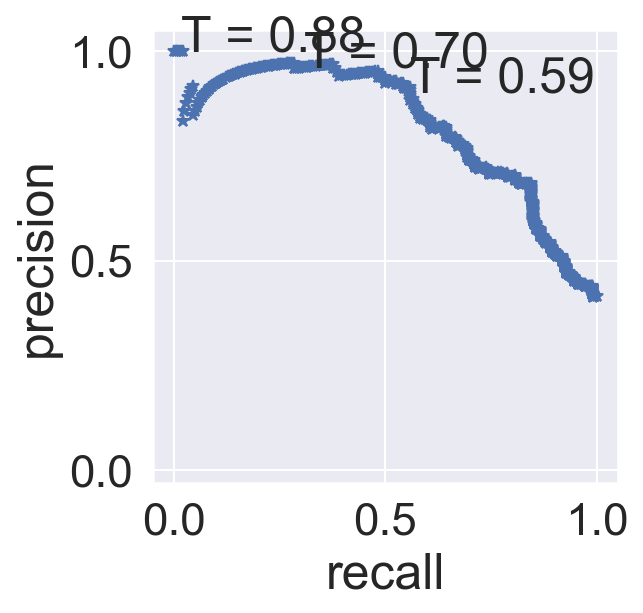

In [33]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_train["survived"],
                                                       lm_probabilities[:, 1])
plt.plot(recall, precision, '*')
plt.xlabel("recall")
plt.ylabel("precision")
plt.text(recall[467], precision[467], f"T = {thresholds[467]:.2f}")
plt.text(recall[400], precision[400], f"T = {thresholds[400]:.2f}")
plt.text(recall[540], precision[540], f"T = {thresholds[540]:.2f}")
plt.ylim(-0.03, 1.05)
plt.savefig("precision_vs_recall_lm_better.png", dpi=300, bbox_inches="tight")
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

One common use for a precision-recall curve is to compare two models independent of the specific threshold that they use. For example, let's consider a bad model that just randomly guesses.

In [34]:
class RandomGuesser():

    def predict(self, x):
        return np.random.random(len(x))


rg = RandomGuesser()
random_guesses = rg.predict(df_train[["age", "fare", "pclass", "sex"]])

In [35]:
random_guesses[0:5]

array([0.2148441 , 0.09463218, 0.48859712, 0.89034246, 0.84709382])

Text(0, 0.5, 'precision')

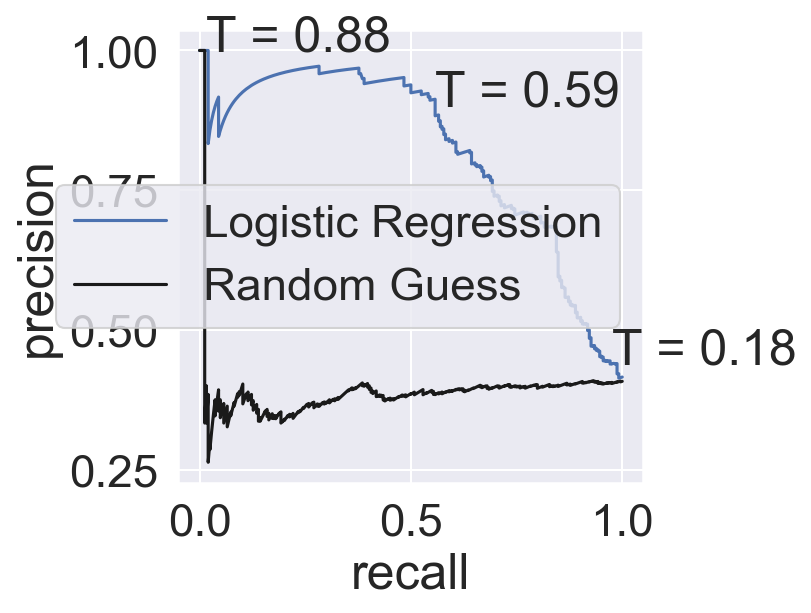

In [38]:
precision_lm, recall_lm, thresholds_lm = precision_recall_curve(
    df_train["survived"], lm_probabilities[:, 1])
precision_rg, recall_rg, thresholds_rg = precision_recall_curve(
    df_train["survived"], random_guesses)
plt.plot(recall_lm, precision_lm)
plt.plot(recall_rg, precision_rg, 'k')
plt.legend(["Logistic Regression", "Random Guess"])
plt.text(recall[40], precision[40], f"T = {thresholds[40]:.2f}")
plt.text(recall[400], precision[400], f"T = {thresholds[400]:.2f}")
plt.text(recall[540], precision[540], f"T = {thresholds[540]:.2f}")
plt.xlabel("recall")
plt.ylabel("precision")

Let's compare the precision-recall curve for the random guesser and the random forest classifier below:

In [39]:
rf = RandomForestClassifier(min_impurity_decrease=0.01, n_estimators=200)
rf.fit(df_train[["age", "fare", "pclass", "sex"]], df_train["survived"])
rf_predictions = rf.predict_proba(df_train[["age", "fare", "pclass", "sex"]])[:,
                                                                              1]

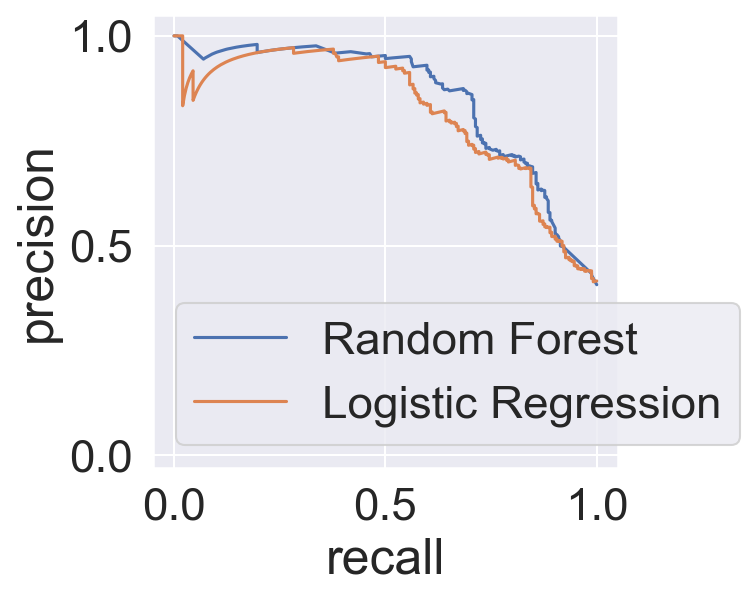

In [40]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    df_train["survived"], rf_predictions)
precision_lm, recall_lm, thresholds_lm = precision_recall_curve(
    df_train["survived"], lm_probabilities[:, 1])

plt.plot(recall_rf, precision_rf)
plt.plot(recall_lm, precision_lm)

#plt.text(recall[40], precision[40], f"T = {thresholds[40]:.2f}")
#plt.text(recall[400], precision[400], f"T = {thresholds[400]:.2f}")
#plt.text(recall[540], precision[540], f"T = {thresholds[540]:.2f}")
plt.xlabel("recall")
plt.ylabel("precision")
plt.ylim(-0.03, 1.05)
plt.legend(["Random Forest", "Logistic Regression"])

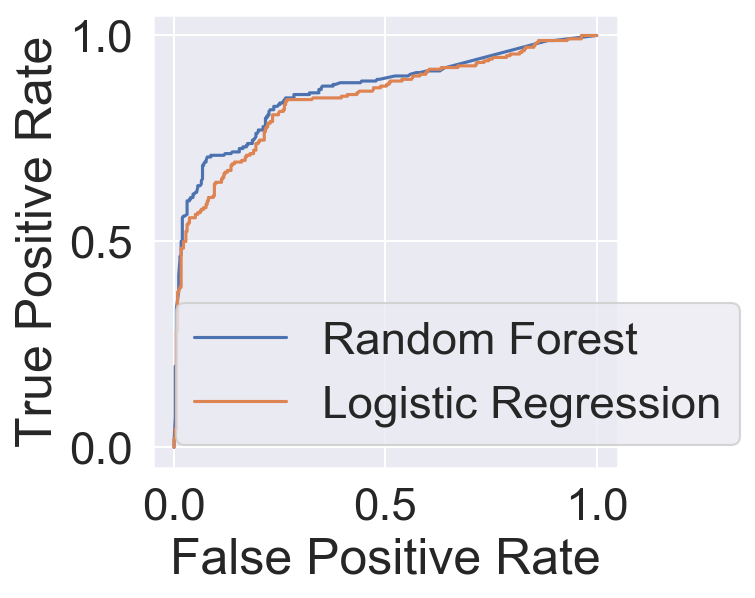

In [49]:
from sklearn.metrics import roc_curve
fpr_lm, tpr_lm, thresholds_lm = roc_curve(df_train["survived"],
                                          lm_probabilities[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(df_train["survived"], rf_predictions)

plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_lm, tpr_lm)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Random Forest", "Logistic Regression"])
plt.savefig("roc_of_rf_vs_lr.png", dpi=300, bbox_inches="tight")

#### Explainable AI

Sometimes we prefer models that are more "explinable". That is, we have a clear understand of exactly how they generated their prediction probabilities.

In [42]:
logistic_model = LogisticRegression(C=1e10)
logistic_model.fit(df_train[["age", "fare", "pclass", "sex"]],
                   df_train["survived"])
logistic_model.coef_

array([[-3.28724731e-02, -1.66319009e-04, -1.26767158e+00,
         2.48727307e+00]])

In [43]:
logistic_model.intercept_

array([2.38881115])

In [44]:
logistic_model.predict_proba([[30, 1, 3, 0]])

array([[0.91686878, 0.08313122]])

The 8% probability we get above can be simply explained in terms of the model coefficients, the data, and the intercept.

In [45]:
def sigma(x):
    return 1 / (1 + np.exp(-x))


sigma(
    np.sum(logistic_model.coef_ * np.array([30, 1, 3, 0])) +
    logistic_model.intercept_)

array([0.08313122])

By contrast, the probabilities generated by the random forest are harder to interpret. There are generated by the votes of 100 separate decision trees.

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(df_train[["age", "fare", "pclass", "sex"]], df_train["survived"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
rf_model.predict([[30, 1, 3, 0]])

array([0], dtype=int64)

In [48]:
rf_model.predict_proba([[30, 1, 3, 0]])

array([[0.62, 0.38]])